# Lesson 5: Fine-Tuning

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

* In this classroom, the libraries have been already installed for you.
* If you would like to run this code on your own machine, you need to install the following:
    ```
    !pip install -q accelerate torch diffusers transformers comet_ml
    ```

In [1]:
# in notebook environment with multiple kernels it allows to install in the current kernel 
# environment, otherwise we can get ModuleNotFoundError: No module named 'comet_ml' even
# after running !pip install comet_ml
import sys
!{sys.executable} -m pip install -q accelerate torch diffusers transformers comet_ml

In [2]:
# was absent in the orig notebook
!{sys.executable} -m pip install -q peft

In [20]:
# without this upgrade installing xformers later can lead to incompatible versions of torch and torchvision
!{sys.executable} -m pip install -q torch==2.4.0 torchvision torchaudio --upgrade

### Set up Comet

* Here you will use the [HuggingFace DreamBooth](https://huggingface.co/docs/diffusers/en/training/dreambooth) training.

In [4]:
import comet_ml

In [5]:
comet_ml.init(anonymous=True)

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()
COMET INFO: Comet is now logging experiments in anonymous mode, they will be publicly accessing by using the experiment url


### Import and prepare the model

In [6]:
import torch

if torch.cuda.is_available():
    model_name = 'stabilityai/stable-diffusion-xl-base-1.0'
else:
    model_name = './models/runwayml/stable-diffusion-v1-5'

In [7]:
# Define hyperparameters

hyperparameters = {
    "instance_prompt": "a photo of a [V] man",
    "class_prompt": "a photo of a man",
    "seed": 4329,
    "pretrained_model_name_or_path": model_name,
    "resolution": 1024 if torch.cuda.is_available() else 512,
    "num_inference_steps": 50,
    "guidance_scale": 5.0,
    "num_class_images": 200,
    "prior_loss_weight": 1.0
}

* Set new **Comet** experiment

In [8]:
experiment = comet_ml.Experiment()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/olive-goldfish-1948/anonymous-project/6fd0a26c4285413692b32db04cd84306

COMET INFO: Couldn't find a Git repository in '/mnt/batch/tasks/shared/LS_root/mounts/clusters/pectogpucomput/code/Users/vladimir.gorovoy/StableDiffusionFineTuning' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


### Load images

In [10]:
from utils import DreamBoothTrainer

/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
2024-09-03 20:38:16.542672: E external/

In [11]:
trainer = DreamBoothTrainer(hyperparameters)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
09/03/2024 20:38:26 - INFO - utils - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



#### Note
- The code that generates images requires a GPU to run.
- The code is left here in markdown, but if you have access to GPUs outside of the classroom, you can run it there.
- In the classroom, you'll still be able to follow along by retrieving the generated images from the experiment tracking tool (Comet).

```Python
# To run the training pipeline
trainer.generate_class_images()
```

```Python
# To see the content of generate_class_image
??trainer.generate_class_images
```

In [26]:
??trainer.generate_class_images

#### Get class images (using artifacts).

In [25]:
import shutil

In [26]:
# Get images
class_artifact = experiment.get_artifact('ckaiser/class-images-15')
class_artifact.download('./')

COMET INFO: Artifact 'ckaiser/class-images-15:1.0.0' download has been started asynchronously
COMET INFO: Still downloading 1 file(s), remaining 3.45 MB/3.45 MB
COMET INFO: Artifact 'ckaiser/class-images-15:1.0.0' has been successfully downloaded


Artifact(name='class-images-15', artifact_type='data', version=None, aliases=set(), version_tags=set())

In [27]:
shutil.unpack_archive('./class.zip', './class')

>Note: the images referenced in this notebook have already been uploaded to the Jupyter directory, in this classroom, for your convenience. For further details, please refer to the **Appendix** section located at the end of the lessons.

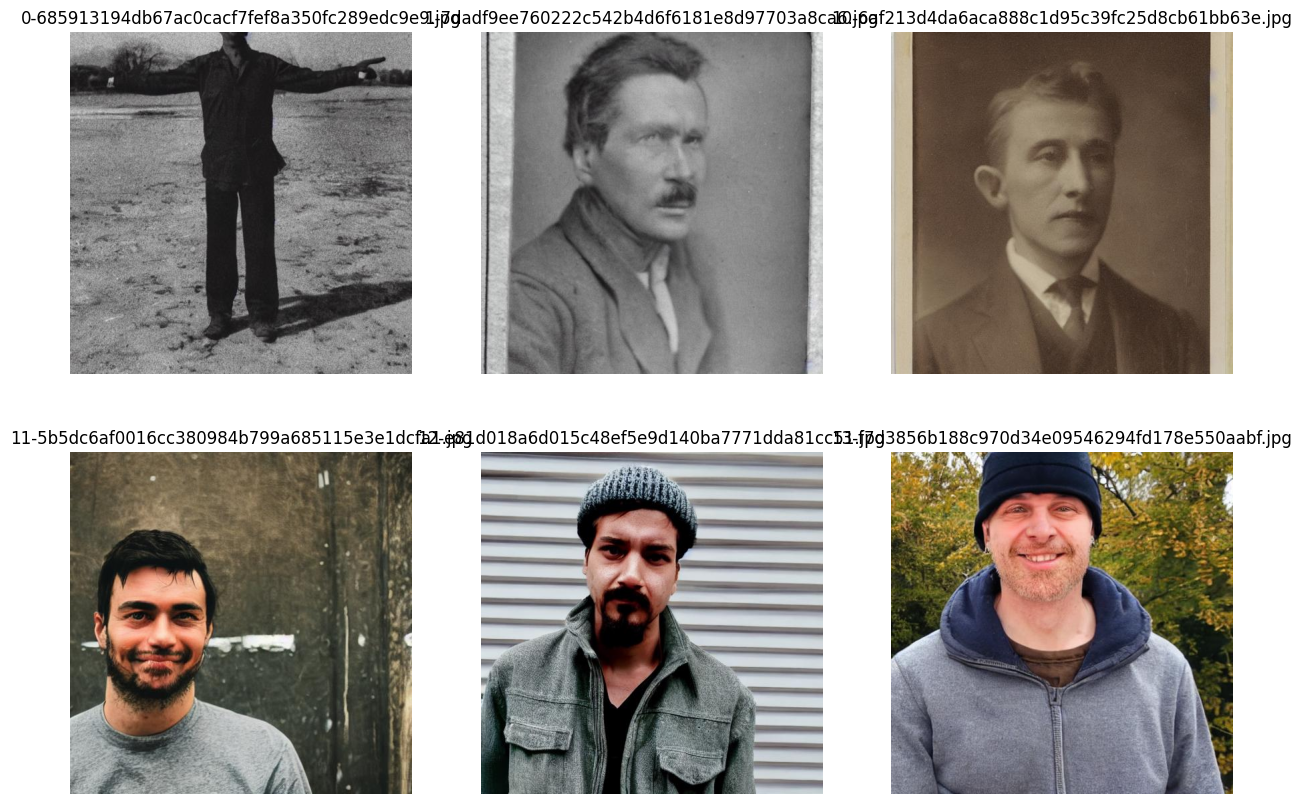

In [12]:
# Print some images
trainer.display_images("class")

* Get the instance dataset (images of Andrew)

In [12]:
andrew_artifact = experiment.get_artifact('ckaiser/andrew-dataset')
andrew_artifact.download('./')

shutil.unpack_archive('./andrew-dataset.zip', './instance')

COMET INFO: Artifact 'ckaiser/andrew-dataset:1.0.0' download has been started asynchronously
COMET INFO: Still downloading 1 file(s), remaining 655.54 KB/655.54 KB
COMET INFO: Artifact 'ckaiser/andrew-dataset:1.0.0' has been successfully downloaded


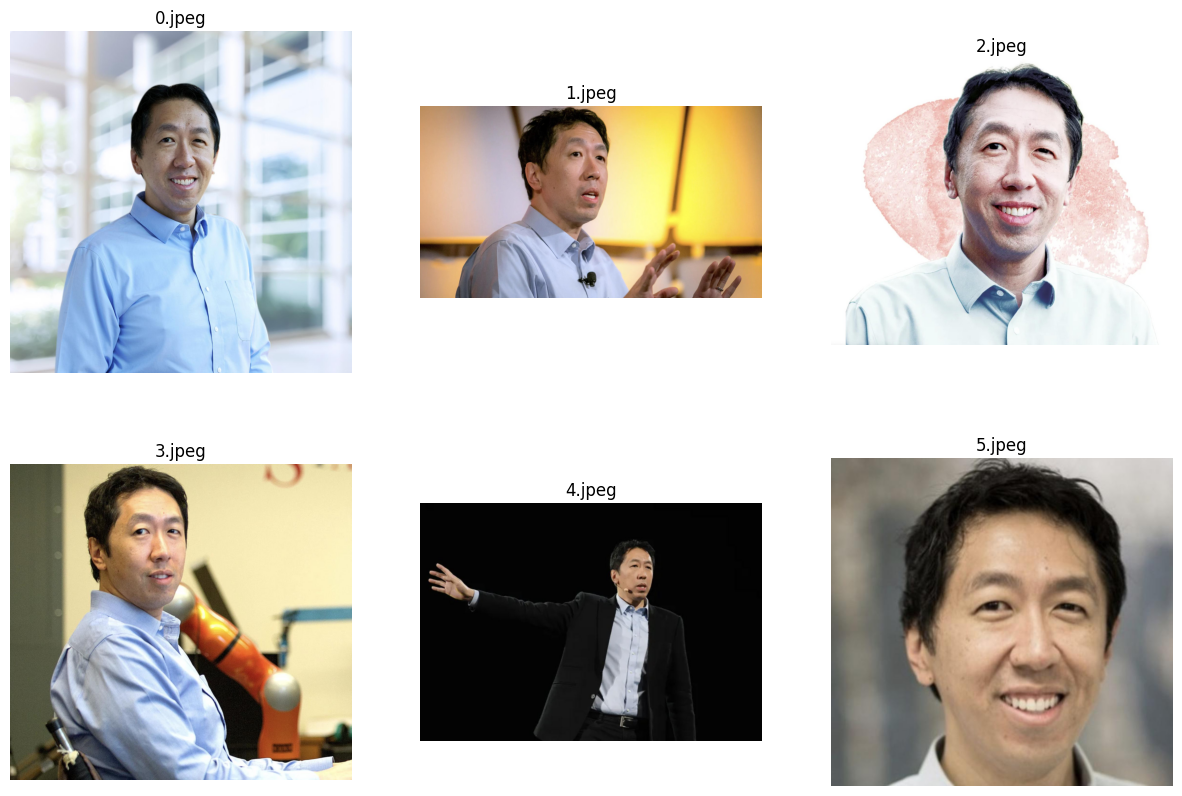

In [13]:
# Print some images
trainer.display_images("instance")

### Initialize the model
- It will take some time (several minutes) to initialize the model.

In [19]:
# wasn't in the original notebook
!{sys.executable} -m pip install -q xformers

In [15]:
tokenizer, text_encoder, vae, unet = trainer.initialize_models()

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'use_post_quant_conv', 'mid_block_add_attention', 'latents_std', 'use_quant_conv', 'shift_factor', 'latents_mean'} was not found in config. Values will be initialized to default values.
{'reverse_transformer_layers_per_block', 'attention_type', 'dropout'} was not found in config. Values will be initialized to default values.


> Note: see the video lesson for the LoRA explanation.

In [16]:
# Add noise to generate images in Stable Diffusion
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler.from_pretrained(
    trainer.hyperparameters.pretrained_model_name_or_path,
    subfolder="scheduler"
)

{'thresholding', 'dynamic_thresholding_ratio', 'variance_type', 'clip_sample_range', 'rescale_betas_zero_snr'} was not found in config. Values will be initialized to default values.


In [17]:
unet = trainer.initialize_lora(unet)

In [22]:
# wasn't in the original notebooks
!{sys.executable} -m pip install -q bitsandbytes

In [23]:
optimizer, params_to_optimize = trainer.initialize_optimizer(unet)

In [18]:
# Initialize the datasets
train_dataset, train_dataloader = trainer.prepare_dataset(tokenizer, text_encoder)
lr_scheduler = trainer.initialize_scheduler(train_dataloader, optimizer)

In [19]:
unet, optimizer, train_dataloader, lr_scheduler = trainer.accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler)

In [20]:
total_batch_size = \
    trainer.hyperparameters.train_batch_size * \
    trainer.hyperparameters.gradient_accumulation_steps

#### Note
- Starting from this point, the code demonstrated by the instructor will not execute in this notebook due to computational resource constraints. However, we provide the code here for you to run if you have access to a GPU or similar resources.
- Thank you for your understanding as we work to provide free and accessible courses.

```Python
from tqdm import tqdm

global_step = 0
epoch = 0

progress_bar = tqdm(
    range(0, trainer.hyperparameters.max_train_steps),
    desc="Steps"
)
```

```Python
for epoch in range(0, trainer.hyperparameters.num_train_epochs):
    unet.train()

    for step, batch in enumerate(train_dataloader):
        with trainer.accelerator.accumulate(unet):
            pixel_values = batch["pixel_values"].to(dtype=vae.dtype)
            model_input = vae.encode(pixel_values).latent_dist.sample()
            model_input = model_input * vae.config.scaling_factor

            noise = torch.randn_like(model_input)
            bsz, channels, height, width = model_input.shape

            timesteps = torch.randint(
                0,
                noise_scheduler.config_num_train_timesteps,
                (bsz,),
                device=model_input.device
            )

            timesteps = timesteps.long()
            noisy_model_input = noise_scheduler.add_noise(
                model_input,
                noise,
                timesteps
            )

            encoder_hidden_states = batch["input_ids"]

            model_predict = unet(
                noisy_model_input,
                timesteps,
                encoder_hidden_states,
                return_dic=False,
            )[0]

            target = noise

            model_pred, model_pred_prior = torch.chunk(model_pred, 2, dim=0)
            target, target_prior = torch.chunk(target, 2, dim=0)

            instance_loss = \
                F.mse_loss(
                    model_pred.float(),
                    target.float(),
                    reduction="mean"
                )
            
            prior_loss = \
                F.mse_loss(
                    model_pred_prior.float(),
                    target_prior.float(),
                    eduction="mean"
                )
            
            loss = \
                instance_loss + \
                trainer.hyperparameters.prior_loss_weight * \
                prior_loss
            
            trainer.accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            global_step +=1

        loss_metrics = {
            "loss": loss.detach().item,
            "prior_loss": prior_loss.detach().item,
            "lr": lr_scheduler.get_last_lr()[0],
        }

        experiment.log_metrics(loss_metrics, step=global_step)

        progress_bar.set_postfix(**loss_metrics)
        progress_bar.update(1)


        if global_step >= trainer.hyperparameters.max_train_steps:
            break

    trainer.save_lora_weights(unet)
experiment.add_tag(f"dreambooth-training")
experiment.log_parameteres(trainer.hyperparameters)
trainer.accelerator.end_training()
```

#### Retrieve the training results
- You can get the training results using the experiment tracking tool, Comet.

In [21]:
training_experiment = \
    comet_ml.APIExperiment(
        previous_experiment="d92519b1f657497e8569a2c8e989b457"
    )


In [22]:
# See the experiment
training_experiment.display()


* Prompts to generate images of Andrew.

In [23]:
prompts = [
    "a photo of a [V] man playing basketball",
    "a photo of a [V] man riding a horse",
    "a photo of a [V] man at the summit of a mountain",
    "a photo of a [V] man driving a convertible",
    "a photo of a [V] man riding a skateboard on a huge halfpipe",
    "a mural of a [V] man, painted by graffiti artists"
]

validation_prompts = [
    "a photo of a man playing basketball",
    "a photo of a man riding a horse",
    "a photo of a man at the summit of a mountain",
    "a photo of a man driving a convertible",
    "a photo of a man riding a skateboard on a huge halfpipe",
    "a mural of a man, painted by graffiti artists"
]

#### Note
- The folowing code requires GPUs.

```Python
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipeline.load_lora_weights("./andrew-model")

for prompt in prompts:
    with torch.no_grad():
        images = pipeline(
            prompt = prompt,
        ).images

        experiment.log_image(images[0], metadata={
            "prompt": prompt,
            "model": hyperparameters.pretrained_model_name_or_path,
        })

for prompt in validation_prompts:
    with torch.no_grad():
        images = pipeline(
            prompt=prompt,
        ).images

    experiment.log_image(images[0], metadata={
            "prompt": prompt,
            "model": hyperparameters.pretrained_model_name_or_path,
        })
```

#### Retrieve the image generation results
- You can view the results of image generation regardless of whether you have access to GPUs, using the experiment tracking tool.

In [24]:
inference_experiment = comet_ml.APIExperiment(
        previous_experiment="0eb292126ab5476ab0c863061a400bdc"
    )


In [25]:
# See the experiment
inference_experiment.display(tab="images")


### Additional Resources
* For more on how to use [Comet](https://www.comet.com/site/?utm_source=dlai&utm_medium=course&utm_campaign=prompt_engineering_for_vision_models&utm_content=dlai_L5) for experiment tracking, check out this [Quickstart Guide](https://colab.research.google.com/drive/1jj9BgsFApkqnpPMLCHSDH-5MoL_bjvYq?usp=sharing) and the [Comet Docs](https://www.comet.com/docs/v2/?utm_source=dlai&utm_medium=course&utm_campaign=prompt_engineering_for_vision_models&utm_content=dlai_L5).
* This course was based off a set of two blog articles from Comet. Explore them here for more on how to use newer versions of Stable Diffusion in this pipeline, additional tricks to improve your inpainting results, and a breakdown of the pipeline architecture:
  * [SAM + Stable Diffusion for Text-to-Image Inpainting](https://www.comet.com/site/blog/sam-stable-diffusion-for-text-to-image-inpainting/?utm_source=dlai&utm_medium=course&utm_campaign=prompt_engineering_for_vision_models&utm_content=dlai_L5)
  * [Image Inpainting for SDXL 1.0 Base Model + Refiner](https://www.comet.com/site/blog/image-inpainting-for-sdxl-1-0-base-refiner/?utm_source=dlai&utm_medium=course&utm_campaign=prompt_engineering_for_vision_models&utm_content=dlai_L5)

## Did you like this course?

- If you liked this course, could you consider giving a rating and share what you liked? 💕
- If you did not like this course, could you also please share what you think could have made it better? 🙏

#### A note about the "Course Review" page.
The rating options are from 0 to 10, and used to calculate the "Net Promoter Score"
- A score of 9 or 10 means you like the course.💫 💕
- A score of 7 or 8 means you feel neutral about the course (neither like nor dislike). 🙄
- A score of 0,1,2,3,4,5 or 6 all mean that you do not like the course. 😭 